# Introduction To Bolt

Hello! This is an intro to $\texttt{Bolt}$ to help you understand the structure of the framework. This way you'll hit the hit the ground running when you want to introduce models of your own. :)

$\texttt{Bolt}$ is a solver framework for kinetic theories and can be used to obtain solution for any equation of the following forms:

Conservative:
\begin{align*}
\frac{\partial f}{\partial t} + \frac{\partial (C_{q1} f)}{\partial q_1} + \frac{\partial (C_{q2} f)}{\partial q_2} +  \frac{\partial (C_{p1} f)}{\partial p_1} + \frac{\partial (C_{p2} f)}{\partial p_2} + \frac{\partial (C_{p3} f)}{\partial p_3} = S(f)
\end{align*}

Non-Conservative:
\begin{align*}
\frac{\partial f}{\partial t} + A_{q1} \frac{\partial f}{\partial q_1} + A_{q2} \frac{\partial f}{\partial q_2} + A_{p1} \frac{\partial f}{\partial p_1} + A_{p2} \frac{\partial f}{\partial p_2} + A_{p3} \frac{\partial f}{\partial p_3} = S(f)
\end{align*}

Where $A_{q1}$, $A_{q2}$, $A_{p1}$, $A_{p2}$, $A_{p3}$,$C_{q1}$, $C_{q2}$, $C_{p1}$, $C_{p2}$, $C_{p3}$ and $S(f)$  are terms that need to be coded in by the user. `Bolt` can make use of the advective semi-lagrangian method and/or the finite-volume method. While the advective semi-lagrangian method makes use of $A_{q1, q2, p1, p2, p3}$, while the finite volume method makes use of $C_{q1, q2, p1, p2, p3}$.

In this tutorial we'll be considering non-relativistic Boltzmann equation, with the BGK collision operator:

\begin{align*}
\frac{\partial f}{\partial t} + v_x \frac{\partial f}{\partial x} + v_y \frac{\partial f}{\partial y} + \frac{q}{m}(\vec{E} + \vec{v} \times \vec{B})_x \frac{\partial f}{\partial v_x} + \frac{q}{m}(\vec{E} + \vec{v} \times \vec{B})_y \frac{\partial f}{\partial v_y} + \frac{q}{m}(\vec{E} + \vec{v} \times \vec{B})_z \frac{\partial f}{\partial v_z} = C[f] = -\frac{f - f_0}{\tau}
\end{align*}

So for this model, we have the following:

$A_{q1} = C_{q1} = v_x$

$A_{q2} = C_{q2} = v_y$

$A_{p1} = C_{p1} = \frac{q}{m}(\vec{E} + \vec{v} \times \vec{B})_x$

$A_{p2} = C_{p2} = \frac{q}{m}(\vec{E} + \vec{v} \times \vec{B})_y$

$A_{p3} = C_{p3} = \frac{q}{m}(\vec{E} + \vec{v} \times \vec{B})_z$

$S(f) = -\frac{f-f_0}{\tau}$, where $f_0$ is the local-maxwellian distribution $\tau$ is the collison timescale.

Additionally, we've taken the generalized the canonical coordinates $p_1$, $p_2$ and $p_3$ to be the velocity values $v_x$, $v_y$, $v_z$. That is:

$p_1 = v_x$

$p_2 = v_y$

$p_3 = v_z$

Before we dive into how we introduce this non-relativistic Boltzmann equation into $\texttt{Bolt}$, let's define the example problem that we intend to solve. The problem that we are considering is a simple one: Given an initial perturbation in the number density $n$ in a collisionless periodic 1D domain, how would the amplitude of density vary with time. Basically, we are stating that:

\begin{align*}
n(x, 0) = n_{background} + \delta n_r cos(kx) - \delta n_i sin(kx)
\end{align*}

Now $\texttt{Bolt}$ requires the initial distribution function to be defined which we'll initialize using the Maxwell Boltzmann distribution function. The system that we are modelling here is a 1D1V one. That is, one dimension in position space, and one dimension in velocity space. The initial distribution function would be:

\begin{align*}
f(x, v, t = 0) = n(x, 0) \sqrt{\frac{m}{2 \pi k T}} e^{-\frac{mv^2}{2 k T}}
\end{align*}

The folder in which this notebook is contained has 4 other python files:``boundary_conditions.py``, ``domain.py``, ``initialize.py``, ``params.py`` each of which hold essential information about the system being modelled.

These files when which used with the ``import`` statement are imported as modules. These modules are what we use to use to pass the information to the solvers in ``Bolt``. We'll go ahead and import these modules for now, and explore what each of these files contain step by step.

In [1]:
# Importing problem specific modules:
import boundary_conditions
import domain
import params
import initialize

In [2]:
!cat boundary_conditions.py

in_q1_left  = 'periodic'
in_q1_right = 'periodic'

in_q2_bottom = 'periodic'
in_q2_top    = 'periodic'


As the name suggests ``boundary_conditions.py`` contains the information about the boundary conditions for the setup considered. While the current problem in consideration is for periodic boundary conditions, $\texttt{Bolt}$ also supports Dirichlet, mirror, and shearing box boundary conditions. The setups for these boundary conditions can be found in other example problems. 

In [3]:
!cat domain.py

q1_start = 0
q1_end   = 1
N_q1     = 32

q2_start = 0
q2_end   = 1
N_q2     = 3

p1_start = -10
p1_end   = 10
N_p1     = 32

p2_start = -0.5
p2_end   = 0.5
N_p2     = 1

p3_start = -0.5
p3_end   = 0.5
N_p3     = 1
    
N_ghost_q = 3
N_ghost_p = 0


``domain.py`` contains data about the phase space domain and resolution that has been considered. Note that we've taken the number of grid points along ``q2`` as 3 although it's a 1D problem. It must be ensured that the number of grid zones in ``q1`` and ``q2`` are greater than or equal to the the number of ghost zones that are taken in q space. This is due to an internal restriction placed on us by one of the libraries we use for parallelization. Additionally, we've taken the domain zones and sizes for ``p3`` and ``p3`` such that ``dp2`` and ``dp3`` come out to be one. This way the integral measure, ``dp1 dp2 dp3`` boils down to be ``dp1`` which is then used for moment computations.

In [4]:
!cat params.py

import numpy as np
import arrayfire as af

fields_type       = 'electrostatic'
fields_initialize = 'fft'
fields_solver     = 'fdtd'

solver_method_in_q = 'FVM'
solver_method_in_p = 'FVM'

reconstruction_method_in_q = 'weno5'
reconstruction_method_in_p = 'weno5'

riemann_solver_in_q = 'upwind-flux'
riemann_solver_in_p = 'upwind-flux'

# Dimensionality considered in velocity space:
p_dim = 1

# Number of devices(GPUs/Accelerators) on each node:
num_devices = 1

# Constants:
mass               = [1]
boltzmann_constant = 1
charge             = [-10]

EM_fields_enabled        = False
source_enabled           = False
instantaneous_collisions = False

# Variation of collisional-timescale parameter through phase space:
@af.broadcast
def tau(q1, q2, p1, p2, p3):
    return (0.01 * p1**0 * q1**0)

# Initial Conditions used in initialize:
# Here density refers to number density
density_background     = 1
temperature_background = 1

p1_bulk_background = 0

pert_real = 0.01
pert_imag = 0.02

k_q1 =

Let's go over each of the attributes mentioned above to understand their usage. While some of these attributes are flags and options that need to be mentioned for every system being solved, there are a few attributes which are specific to the non-relativistic Boltzmann system being solved. The ``params`` module can be used to add attributes, and functions which you intend to declare somewhere in ``src/`` :

### Attributes Native To the Solver:

``fields_type`` is used to declare what sort of fields are being solved in the problem of consideration. It can be electrostatic where magnetic fields stay at zero, electrodynamic where magnetic fields are also evolved and user-defined where the evolution of the fields in time are declared by the user(this is primarily used in debugging). This attribute can be set appropriately as ``electrostatic``, ``electrodynamic`` and ``user-defined``. The setup we've considered is an electrostatic one.

``fields_initialize`` is used to declare which method is used to set the initialize the values for the electromagnetic fields. 2 methods are available for initializing electrostatic fields from the density - ``snes`` and ``fft``. The ``fft`` method of initialization can only be used for serial runs with periodic boundary conditions. ``snes`` is  a more versatile method capable of being run in parallel with other boundary conditions as well. It makes use of the SNES routines in PETSc which use Krylov subspace methods to solve for the fields. Additionally, this can also be set to ``user-defined``, where the initial conditions for the electric and magnetic fields are defined in terms of ``q1`` and ``q2`` under initialize.

``fields_solver`` is used to declare which method is used to set the method that is used to evolve the fields with time. The same methods are available for computing electrostatic fields ``snes`` and ``fft``. The ``fdtd`` method is to be used when solving for electrodynamic systems.

``solver_method_in_q`` and ``solver_method_in_p`` are used to set the specific solver method used in q-space and p-space which can be set to ``FVM`` or ``ASL`` for the finite volume method and the advective semi-lagrangian method.

```reconstruction_method_in_q``` and ``reconstruction_method_in_p`` are used to set the specific reconstruction scheme used for the FVM method in q-space and p-space. This can be set to ``piecewise-constant``, ``minmod``, ``ppm`` and ``weno5``. 

``riemann_solver_in_q`` and ``riemann_solver_in_p`` are used to set the specific riemann solver which is to be used for the FVM method in q-space and p-space. This can be set to ``upwind-flux`` for the first order upwind flux method, and ``lax-friedrichs`` for the local Lax-Friedrichs method.

``num_devices`` is used in parallel runs when run on nodes which contain more than a single accelerator. For instance when running on nodes which contain 4 GPUs each, this attribute is set to 4.

``EM_fields_enabled`` is a solver flag which is used to indicate whether the case considered is one where we solve in p-space as well. Similarly, ``source_enabled`` is used to switch on and off the source term. For now, we have set both to ``False``.

``charge`` as the name suggests is used to assign charge to the species considered in the simulation. This is used internally in the fields solver. For this tutorial we've taken the charge of the particle to be -10 units. However this won't matter if ``EM_fields_enabled`` is set to ``False``.

``instantaneous_collisions`` is a flag which is turned on when we want to update the distribution function f to a distribution function array as returned by the source term. For instance in the case of the BGK operator we want to solve $\frac{d f}{d t} = -\frac{f - f_0}{\tau}$. But as $\tau \to 0$, $f = f_0$. For solving systems in the $\tau = 0$ regime this flag is turned to True. How this is carried out is explained further in the section that explains how the equation to be modelled is input.

### Attributes Native To the System Solved:

``p_dim`` is used to set the dimensionality considered in p-space. This becomes important especially for the definition of various physical quantities which vary as a function of the dimensionality and the moments. This would be used in the collision operator as we'll discuss further in this tutorial.

``mass`` and ``boltzmann_constant`` are pretty explanatory from their name, and are used for initialization and defining the system solved.

``tau`` is the collision timescale in the BGK operator and used in solving for the source part of the equation. This parameter would only make a difference in the simulation results if the switch ``source_enabled`` is set to ``True``.

The remaining parameters as they are mentioned are used in the ``initialize`` module

In [5]:
!cat initialize.py

"""
Functions which are used in assigning the I.C's to
the system.
"""

import arrayfire as af
import numpy as np

def initialize_f(q1, q2, p1, p2, p3, params):

    m = params.mass
    k = params.boltzmann_constant

    n_b = params.density_background
    T_b = params.temperature_background

    p1_bulk = params.p1_bulk_background

    pert_real = params.pert_real
    pert_imag = params.pert_imag

    k_q1 = params.k_q1

    # Calculating the perturbed density:
    n = n_b + (  pert_real * af.cos(k_q1 * q1)
               - pert_imag * af.sin(k_q1 * q1)
              )

    f = n * (m / (2 * np.pi * k * T_b))**(1 / 2) \
          * af.exp(-m * (p1 - p1_bulk)**2 / (2 * k * T_b)) \

    af.eval(f)
    return (f)


As you can see the ``initialize`` module contains the function ``initialize_f`` which initializes the distribution function using the parameters that were declared.

Now that we've setup the parameters for the specific test problem that we want to solve, we'll proceed to describe how we input the desired equation of our model into $\texttt{Bolt}$. 

## How the equation to be modelled is introduced into Bolt:

As one navigates from the root folder of this repository into the folder main folder for the package ``bolt``, there's two separate subfolders ``lib`` and ``src``. While all the files in ``lib`` contain the solver algorithms, and the structure for the solvers, ``src`` is where we introduce the models that we intend to model. For instance, the files that we'll be using for this test problem can be found under ``bolt/src/nonrelativistic_boltzmann``. First let's import all necessary modules.

In [6]:
import bolt.src.nonrelativistic_boltzmann.advection_terms as advection_terms
import bolt.src.nonrelativistic_boltzmann.collision_operator as collision_operator
import bolt.src.nonrelativistic_boltzmann.moments as moments

Let's start of by seeing how we've introduced the advection terms specific to the non-relativistic Boltzmann equation into the framework of $\texttt{Bolt}$. Advection terms are introduced into $\texttt{Bolt}$ through the ``advection_terms`` which has the functions ``A_q, C_q, C_p, C_p``. 

It is expected that ``A_q`` and ``C_q`` take the arguments ``(f, t, q1, q2, v1, v2, v3, params)``, where `f` is the distribution function, `t` is the time elapsed, `(q1, q2, v1, v2, v3)` are phase space grid data for the position space and velocity space respectively. Additionally, it also accepts a module ``params`` which can take contain user defined attributes and functions that can be injected into this function.

While ``A_p`` and ``C_p`` take all the arguments that are taken by ``A_q`` and ``C_q``, it also takes the additional argument of a ``fields_solver`` object. The ``get_fields()`` method of this object returns the electromagnetic fields at the current instance. The ``fields_solver`` objects are internal to the solvers, and can be chosen as an electrostatic and electrodynamic as we've seen in the parameters above.

In [7]:
!cat $BOLT_HOME/bolt/src/nonrelativistic_boltzmann/advection_terms.py

#!/usr/bin/env python3 
# -*- coding: utf-8 -*-

"""
Here we define the advection terms for the 
nonrelativistic Boltzmann equation.

The equation that we are solving is:

df/dt + v_x * df/dq1 + v_y * df/dy + (E + v X B)_x * df/dv_x + (E + v X B)_y * df/dv_y + (E + v X B)_y * df/dv_z = 0

In the solver framework this can be described using:

q1 = x  ; q2 = y
p1 = v1 = v_x; p2 = v2 = v_y; p3 = v3 = v_z

A_q1 = C_q1 = v_x = v1
A_q2 = C_q2 = v_y = v2

A_v1 = C_v1 = q/m * (E_x + v_y * B_z - v_z * B_y) = q/m * (E1 + v2 * B3 - v3 * B2)
A_v2 = C_v2 = q/m * (E_y + v_z * B_x - v_x * B_z) = q/m * (E2 + v3 * B1 - v1 * B3)
A_v3 = C_v3 = q/m * (E_z + v_x * B_y - v_y * B_x) = q/m * (E3 + v1 * B2 - v2 * B1)
"""

def A_q(f, t, q1, q2, v1, v2, v3, params):
    """
    Return the terms A_q1, A_q2.

    Parameters:
    -----------
    f : Distribution function array
        shape:(N_v, N_s, N_q1, N_q2)
    
    t : Time elapsed
    
    q1 : The array that holds data for the q1 dimension in q-space
     

We hope the model described is quite clear from the docstrings. Note that we describe the model in terms of variables in velocities v and not the canonical variables p to avoid confusion with momentum.

Next, we proceed to see how moments we define moments for our system of interest. 

In [8]:
!cat $BOLT_HOME/bolt/src/nonrelativistic_boltzmann/moments.py

#!/usr/bin/env python3 
# -*- coding: utf-8 -*-

from bolt.src.utils.integral_over_v import integral_over_v

def density(f, v1, v2, v3, integral_measure):
    return(integral_over_v(f, integral_measure))

def mom_v1_bulk(f, v1, v2, v3, integral_measure):
    return(integral_over_v(f * v1, integral_measure))

def mom_v2_bulk(f, v1, v2, v3, integral_measure):
    return(integral_over_v(f * v2, integral_measure))

def mom_v3_bulk(f, v1, v2, v3, integral_measure):
    return(integral_over_v(f * v3, integral_measure))

def energy(f, v1, v2, v3, integral_measure):
    return(integral_over_v(0.5 * f * (v1**2 + v2**2 + v3**2),
                           integral_measure
                          )
          )

def q_q1(f, v1, v2, v3, integral_measure):
    return(integral_over_v(f * v1 * (v1**2 + v2**2 + v3**2),
                           integral_measure
                          )
          )

def q_q2(f, v1, v2, v3, integral_measure):
    return(integral_over_v(f * v2 * (v1**2 + v2**2 + v3*

As you can see all the moment quantities take `(f, v1, v2, v3, integral_measure)` as arguments interms of which we define the moments for the system. By default, ``integral_measure`` is taken to be ``dv1 dv2 dv3``. These definitions are referred to by the solver routine ``compute_moments``, which calls the appropriate moment routine as a string. For instance, if we want to compute density at the current state, calling ``compute_moments('density')`` gets the job done.

It's to be noted that when fields are enabled in the problem of consideration, density, mom_v1_bulk, mom_v1_bulk and mom_v1_bulk must be defined since this is used internally when solving for electromagnetic fields.

**NOTE**: Density is number density here

Now we proceed to the final information regarding our equation which is the source term which in our case is the BGK collision operator.

In [9]:
!cat $BOLT_HOME/bolt/src/nonrelativistic_boltzmann/collision_operator.py

#!/usr/bin/env python3 
# -*- coding: utf-8 -*-

"""Contains the function which returns the Source/Sink term."""

import numpy as np
import arrayfire as af

from bolt.lib.nonlinear.utils.broadcasted_primitive_operations import multiply

# Using af.broadcast, since v1, v2, v3 are of size (1, 1, Nv1*Nv2*Nv3)
# All moment quantities are of shape (Nq1, Nq2)
# By wrapping with af.broadcast, we can perform batched operations
# on arrays of different sizes.
@af.broadcast
def f0(v1, v2, v3, n, T, v1_bulk, v2_bulk, v3_bulk, params):
    """
    Return the Local MB distribution.
    Parameters:
    -----------
    v1 : The array that holds data for the v1 dimension in v-space
         shape:(N_v, N_s, 1, 1)

    v2 : The array that holds data for the v2 dimension in v-space
         shape:(N_v, N_s, 1, 1)

    v3 : The array that holds data for the v3 dimension in v-space
         shape:(N_v, N_s, 1, 1)
    
    n: Computed density at the current state.
       shape:(1, N_s, N_q1, N_q2)

    T: 

Here the BGK function is our source term, and takes the arguments ``(f, t, q1, q2, v1, v2, v3, moments, params, flag)``. Note that ``moments`` is the solver routine of ``compute_moments`` which is used to compute the moments at the current instance of computing the collison operator.

In parameters, we had defined an attribute ``instantaneous_collision`` which when set to ``True``, returns the value that is returned by the source function when ``flag`` is set to ``True``. Above we had mentioned how this maybe necessary in our model when solving for purely collisional cases(hydrodynamic regime)

We'll start by importing dependencies for the solver.

[ArrayFire](https://arrayfire.com/) is a general-purpose library that simplifies the process of developing software that targets parallel and massively-parallel architectures including CPUs, GPUs, and other hardware acceleration devices. $\texttt{Bolt}$ uses it's Python API for the creation and manipulation of arrays which allows us to run our code on a range of devices at optimal speed.

We use NumPy for declaring the time data and storing data which we indend to plot, and pylab(matplotlib), for post-processing.

In [10]:
# Importing dependencies:
import arrayfire as af
import numpy as np
import pylab as pl
%matplotlib inline

In [11]:
# Importing the classes which are used to declare the physical_system and solver objects
from bolt.lib.physical_system import physical_system
from bolt.lib.nonlinear.nonlinear_solver import nonlinear_solver
from bolt.lib.linear.linear_solver import linear_solver

In [12]:
# Optimized plot parameters to make beautiful plots:
pl.rcParams['figure.figsize']  = 12, 7.5
pl.rcParams['figure.dpi']      = 300
pl.rcParams['image.cmap']      = 'jet'
pl.rcParams['lines.linewidth'] = 1.5
pl.rcParams['font.family']     = 'serif'
pl.rcParams['font.weight']     = 'bold'
pl.rcParams['font.size']       = 20
pl.rcParams['font.sans-serif'] = 'serif'
pl.rcParams['text.usetex']     = True
pl.rcParams['axes.linewidth']  = 1.5
pl.rcParams['axes.titlesize']  = 'medium'
pl.rcParams['axes.labelsize']  = 'medium'

pl.rcParams['xtick.major.size'] = 8
pl.rcParams['xtick.minor.size'] = 4
pl.rcParams['xtick.major.pad']  = 8
pl.rcParams['xtick.minor.pad']  = 8
pl.rcParams['xtick.color']      = 'k'
pl.rcParams['xtick.labelsize']  = 'medium'
pl.rcParams['xtick.direction']  = 'in'

pl.rcParams['ytick.major.size'] = 8
pl.rcParams['ytick.minor.size'] = 4
pl.rcParams['ytick.major.pad']  = 8
pl.rcParams['ytick.minor.pad']  = 8
pl.rcParams['ytick.color']      = 'k'
pl.rcParams['ytick.labelsize']  = 'medium'
pl.rcParams['ytick.direction']  = 'in'

We define the system we want to solve through the ``physical_system`` class. This class takes it's arguments as ``(domain, boundary_conditions, params, initialize, advection_terms, source_function, moments)`` which we had explored above. The declared object is then passed to the linear and nonlinear solver objects to provide information about the system solved.

In [13]:
# Defining the physical system to be solved:
system = physical_system(domain,
                         boundary_conditions,
                         params,
                         initialize,
                         advection_terms,
                         collision_operator.BGK,
                         moments
                        )

N_g_q = system.N_ghost_q

# Declaring a linear system object which will evolve the defined physical system:
nls = nonlinear_solver(system)
ls  = linear_solver(system)

In [14]:
# Time parameters:
dt      = 0.001
t_final = 0.5

time_array  = np.arange(0, t_final + dt, dt)

rho_data_nls = np.zeros(time_array.size)
rho_data_ls  = np.zeros(time_array.size)

The default data format in $\texttt{Bolt}$ is ``(Np, Ns, N_q1, N_q2)``, where ``Np`` is the number of zones in p-space, ``Ns`` is the number of species and ``N_q1`` and ``N_q2`` are the number of gridzones along ``q1`` and ``q2`` respectively.

Below since we want to obtain the amplitude for the density in the physical domain non-inclusive of the ghost zones, we use ``max(density[:, :, N_g:-N_g, -N_g:N_g])``. 

In [15]:
# Storing data at time t = 0:
n_nls           = nls.compute_moments('density')
# Check for the data non inclusive of the ghost zones:
rho_data_nls[0] = af.max(n_nls[:, :, N_g_q:-N_g_q, N_g_q:-N_g_q])

n_ls           = ls.compute_moments('density')
rho_data_ls[0] = af.max(n_ls) 

for time_index, t0 in enumerate(time_array[1:]):

    nls.strang_timestep(dt)
    ls.RK4_timestep(dt)

    n_nls                         = nls.compute_moments('density')
    rho_data_nls[time_index + 1]  = af.max(n_nls[:, :, N_g_q:-N_g_q, N_g_q:-N_g_q])
    
    n_ls                        = ls.compute_moments('density')
    rho_data_ls[time_index + 1] = af.max(n_ls) 

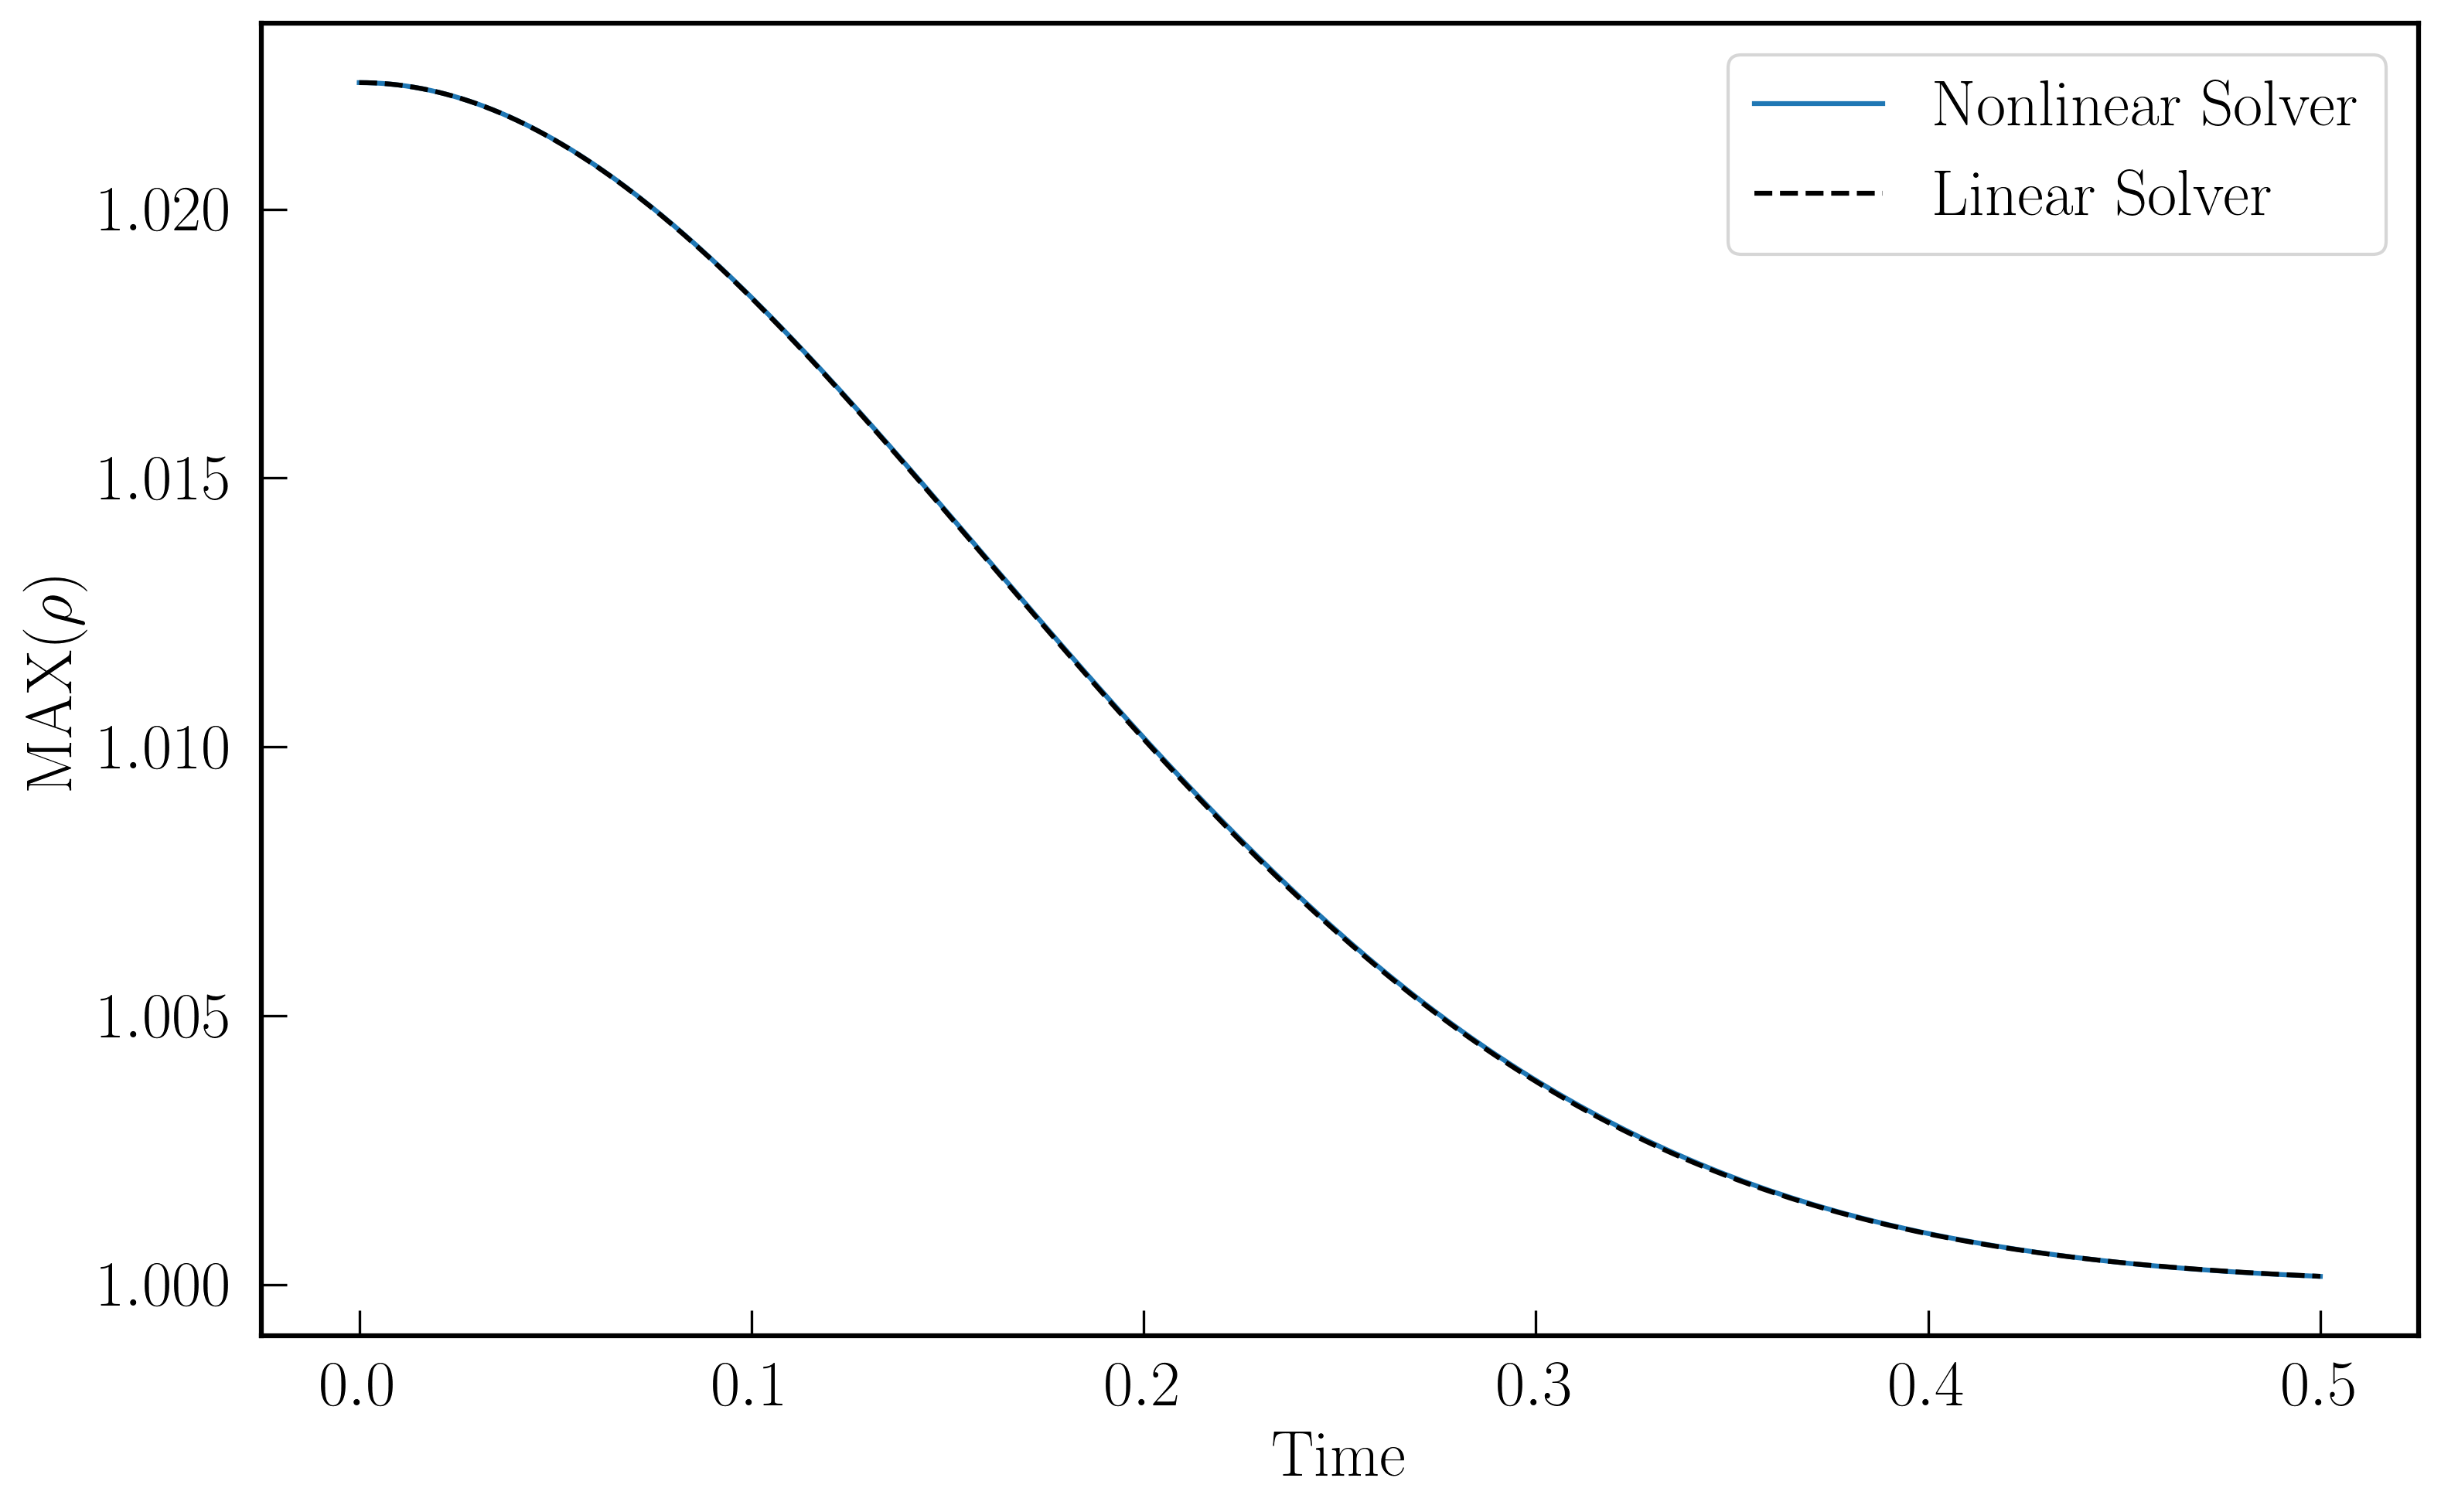

In [16]:
pl.plot(time_array, rho_data_nls, label='Nonlinear Solver')
pl.plot(time_array, rho_data_ls, '--', color = 'black', label = 'Linear Solver')
pl.ylabel(r'MAX($\rho$)')
pl.xlabel('Time')
pl.legend()

Alright! We see good correspondence between the results given by the linear and nonlinear solvers. We have also performed convergence check between the distribution functions given by the linear and nonlinear solvers for this case, and have verified that it obeys $O(N^{-2})$ convergence. These tests may be found under ``example_problems/linear_damping``.

Go ahead and play around with the parameters to see how the results change as the parameters are tweaked. 